In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

In [3]:
import torchvision
from torchvision import models

# MACHINE LEARNING CYCLE
- Import dataset
- Preprocess dataset
- Feature Engineering
- Normalize dataset
- Encode categorical variables
- Create sequences
- Train-Test split
- Choose appropriate ML architecture
- Train model
- Evaluate
- Predict
- Postprocessing

## Import Dataset

In [4]:
df = pd.read_csv('data.csv', parse_dates=['Date'], index_col="Date")
df.head()

,SN,Commodity,Unit,Minimum,Maximum,Average
Date,,,,,,
2013-06-16,0,Tomato Big(Nepali),Kg,35.0,40.0,37.5
2013-06-16,1,Tomato Small(Local),Kg,26.0,32.0,29.0
2013-06-16,2,Potato Red,Kg,20.0,21.0,20.5
2013-06-16,3,Potato White,Kg,15.0,16.0,15.5
2013-06-16,4,Onion Dry (Indian),Kg,28.0,30.0,29.0


## Preprocess dataset

In [5]:
df = df.drop(['SN', 'Unit'], axis=1)
df.ffill(inplace=True)

## Feature Engineering

In [6]:
df['prev_max_price'] = df['Maximum'].shift(1)
df['prev_min_price'] = df['Minimum'].shift(1)
df['prev_avg_price'] = df['Average'].shift(1)

df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month
df['year'] = df.index.year

# Drop rows with NaN values after shifting
df.dropna(inplace=True)

## Normalize dataset

In [7]:
scaler = MinMaxScaler()
numerical_features = ['Maximum', 'Minimum', 'Average', 'prev_max_price', 'prev_min_price', 'prev_avg_price']
df[numerical_features] = scaler.fit_transform(df[numerical_features])

## Encode Categorical variables

In [8]:
# this is like an identity matrix u use in gaussian method of solving linear equations
df = pd.get_dummies(df, columns=['Commodity'], drop_first=True, dtype=int)
df = df.apply(pd.to_numeric, errors='coerce')
df.head()

,Minimum,Maximum,Average,prev_max_price,prev_min_price,prev_avg_price,day_of_week,month,year,Commodity_Apple(Jholey),...,Commodity_Tomato Big(Nepali),Commodity_Tomato Small(Indian),Commodity_Tomato Small(Local),Commodity_Tomato Small(Terai),Commodity_Tomato Small(Tunnel),Commodity_Turnip,Commodity_Turnip A,Commodity_Water Melon(Dotted),Commodity_Water Melon(Green),Commodity_Yam
Date,,,,,,,,,,,,,,,,,,,,,
2013-06-16,0.013897,0.013039,0.012665,0.017051,0.018899,0.017150,6,6,2013,0,...,0,0,1,0,0,0,0,0,0,0
2013-06-16,0.010561,0.007523,0.008179,0.013039,0.013897,0.012665,6,6,2013,0,...,0,0,0,0,0,0,0,0,0,0
2013-06-16,0.007782,0.005015,0.005541,0.007523,0.010561,0.008179,6,6,2013,0,...,0,0,0,0,0,0,0,0,0,0
2013-06-16,0.015008,0.012036,0.012665,0.005015,0.007782,0.005541,6,6,2013,0,...,0,0,0,0,0,0,0,0,0,0
2013-06-16,0.016120,0.014544,0.014512,0.012036,0.015008,0.012665,6,6,2013,0,...,0,0,0,0,0,0,0,0,0,0


## Create Sequences


In [9]:
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in tqdm(range(len(data) - seq_length)):
        x = data.iloc[i:(i + seq_length)].drop(columns=['Maximum', 'Minimum', 'Average']).values
        y = data.iloc[i + seq_length][['Maximum', 'Minimum', 'Average']].values
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [10]:
# Use 30 days of data to predict the next day
seq_length = 30
X, y = create_sequences(df, seq_length)

100%|████████████████████████████████████████████████████████████████████████| 197130/197130 [03:14<00:00, 1011.35it/s]


## Train-Test Split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Formula for Convolution layers:
$O = \frac{I-F+2\times{P}}{S}$  

where,  
O = Output channels  
I = Input channels  
F = Filter (kernel) size  
P = Padding  
S = Stride  

## Choose APPROPRIATE ML Architecture

In [12]:
X_train.shape, X_test.shape

((157704, 30, 137), (39426, 30, 137))

In [13]:
class ConvNet(nn.Module):
    def __init__(self, in_channels, out_channels, seq_length):
        super().__init__()
        self.convolution = nn.Sequential(
            nn.Conv1d(in_channels, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.BatchNorm1d(32),
            nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.BatchNorm1d(64)
        )
        self.flatten = nn.Flatten()
        num_ftrs = self._get_ftrs(seq_length)
        self.fc = nn.Sequential(
            nn.Linear(64 * (seq_length // 4), 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, out_channels)
        )
    def _get_ftrs(self, seq_len):
        dummy_input = torch.randn(1, 137, seq_len)
        features = self.convolution(dummy_input)
        num_features = features.view(features.size(0), -1).size(1)
        return num_features
        
    def forward(self, x):
        x = self.convolution(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

In [14]:
X_train = torch.tensor(X_train, dtype=torch.float32).permute(0, 2, 1)
X_test = torch.tensor(X_test, dtype=torch.float32).permute(0, 2, 1)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

## Train Model

In [15]:
# output_size = 3 cuz 3 different levels of prices: Minimum, Maximum and Average
model = ConvNet(in_channels=X_train.shape[1], out_channels=3, seq_length=seq_length)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [16]:
num_epochs = 25
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print("Training complete")

Epoch [1/25], Loss: 0.1090
Epoch [2/25], Loss: 0.0750
Epoch [3/25], Loss: 0.0574
Epoch [4/25], Loss: 0.0354
Epoch [5/25], Loss: 0.0230
Epoch [6/25], Loss: 0.0176
Epoch [7/25], Loss: 0.0142
Epoch [8/25], Loss: 0.0109
Epoch [9/25], Loss: 0.0081
Epoch [10/25], Loss: 0.0066
Epoch [11/25], Loss: 0.0052
Epoch [12/25], Loss: 0.0043
Epoch [13/25], Loss: 0.0037
Epoch [14/25], Loss: 0.0034
Epoch [15/25], Loss: 0.0033
Epoch [16/25], Loss: 0.0032
Epoch [17/25], Loss: 0.0031
Epoch [18/25], Loss: 0.0030
Epoch [19/25], Loss: 0.0029
Epoch [20/25], Loss: 0.0028
Epoch [21/25], Loss: 0.0027
Epoch [22/25], Loss: 0.0026
Epoch [23/25], Loss: 0.0026
Epoch [24/25], Loss: 0.0025
Epoch [25/25], Loss: 0.0025
Training complete


## Evaluate Model

In [21]:
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    print(f'Test Loss: {test_loss.item():.4f}')

print("Testing complete")

Test Loss: 8.4354
Testing complete


## Make Predictions

In [18]:
# testing for tommorrow's price based on last day's price
new_data = X_test[-1].unsqueeze(0)
predicted_prices = model(new_data)
print(predicted_prices)

tensor([[ 4.9655, -0.3252, -1.0662]], grad_fn=<AddmmBackward0>)


## Visualization

In [19]:
model.eval()
with torch.no_grad():
    predictions = model(X_test)

In [20]:
predictions.shape

torch.Size([39426, 3])

In [22]:
# Ensure tensor is converted to numpy
predicted_prices = predictions.detach().numpy()

# Pad with zeros for missing columns
pad_size = scaler.min_.shape[0] - predicted_prices.shape[1]
padded_predictions = np.concatenate([predicted_prices, np.zeros((predicted_prices.shape[0], pad_size))], axis=1)

# Apply inverse transform
original_scale_predictions = scaler.inverse_transform(padded_predictions)

# Extract only relevant values (first 3 columns)
original_scale_predictions = original_scale_predictions[:, :predicted_prices.shape[1]]

In [23]:
print(original_scale_predictions.shape, predicted_prices.shape)

(39426, 3) (39426, 3)


In [24]:
# Create a DataFrame for visualization
results = pd.DataFrame({
    'Date': df.index[-len(y_test):],  # Use the dates from the original dataset
    'Actual Max Price': y_test[:, 0],  # Actual max prices
    'Predicted Max Price': predictions[:, 0],  # Predicted max prices
    'Actual Min Price': y_test[:, 1],  # Actual min prices
    'Predicted Min Price': predictions[:, 1],  # Predicted min prices
    'Actual Avg Price': y_test[:, 2],  # Actual avg prices
    'Predicted Avg Price': predictions[:, 2]   # Predicted avg prices
})

In [25]:
results.head()

,Date,Actual Max Price,Predicted Max Price,Actual Min Price,Predicted Min Price,Actual Avg Price,Predicted Avg Price
0,2020-01-04,0.022066,5.017795,0.021679,-0.227756,0.021108,-0.989928
1,2020-01-04,0.047141,5.016352,0.049472,-0.233253,0.047493,-0.978357
2,2020-01-04,0.047141,5.006567,0.049472,-0.244348,0.047493,-0.985479
3,2020-01-04,0.047141,5.013335,0.049472,-0.236440,0.047493,-0.988365
4,2020-01-04,0.082247,5.015951,0.088382,-0.243074,0.084433,-1.001347


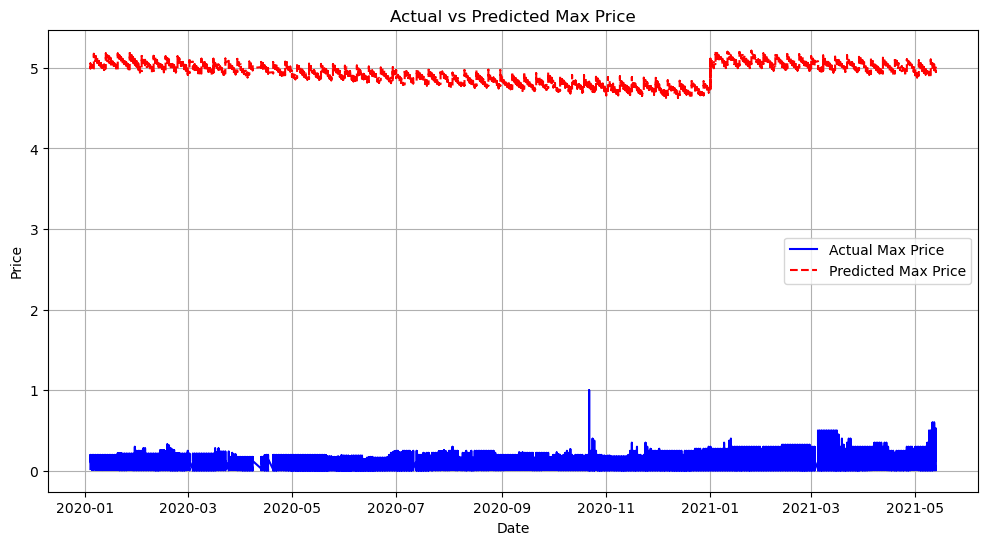

In [26]:
# Max Prices

plt.figure(figsize=(12, 6))
plt.plot(results['Date'], results['Actual Max Price'], label='Actual Max Price', color='blue')
plt.plot(results['Date'], results['Predicted Max Price'], label='Predicted Max Price', color='red', linestyle='--')
plt.title('Actual vs Predicted Max Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

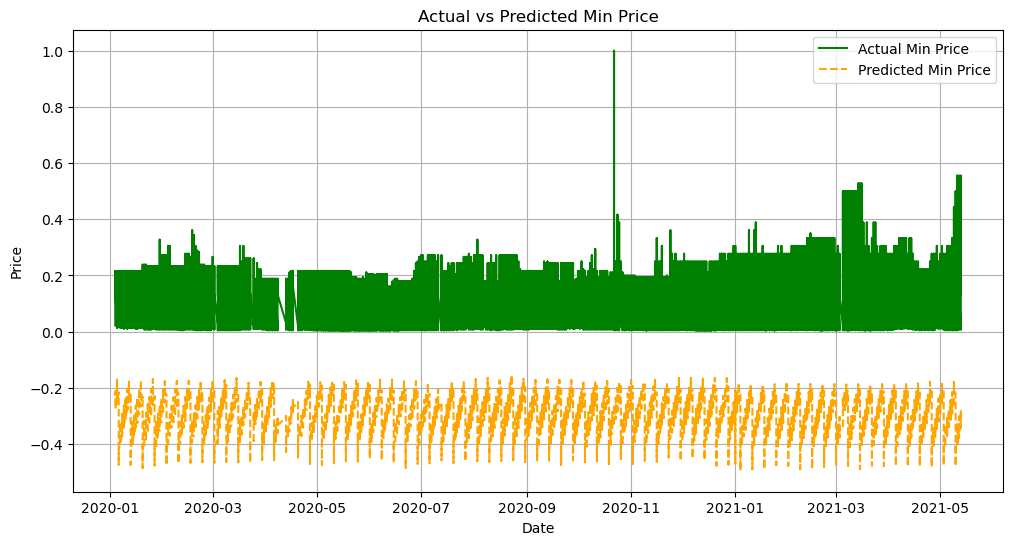

In [27]:
# Min Prices

plt.figure(figsize=(12, 6))
plt.plot(results['Date'], results['Actual Min Price'], label='Actual Min Price', color='green')
plt.plot(results['Date'], results['Predicted Min Price'], label='Predicted Min Price', color='orange', linestyle='--')
plt.title('Actual vs Predicted Min Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

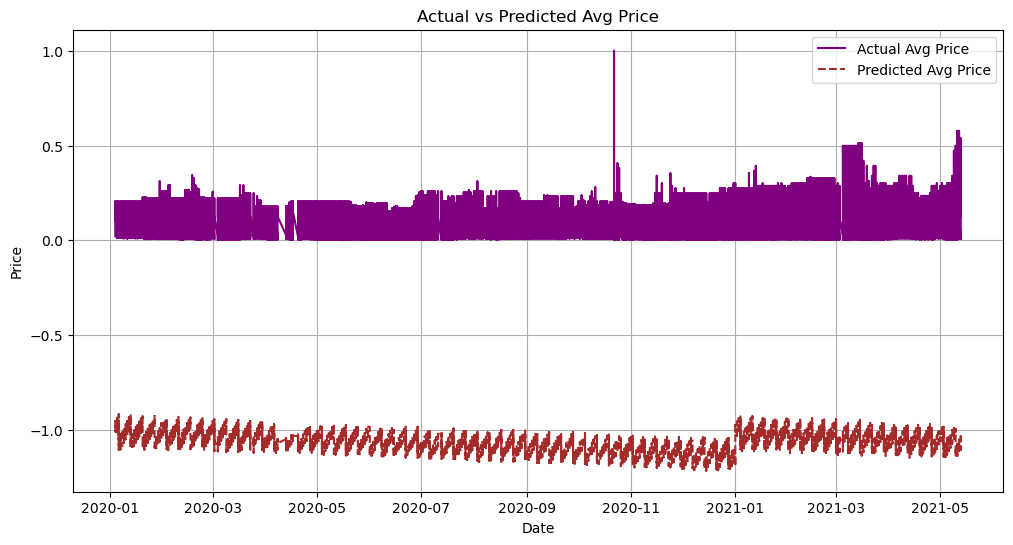

In [28]:
# Avg Prices

plt.figure(figsize=(12, 6))
plt.plot(results['Date'], results['Actual Avg Price'], label='Actual Avg Price', color='purple')
plt.plot(results['Date'], results['Predicted Avg Price'], label='Predicted Avg Price', color='brown', linestyle='--')
plt.title('Actual vs Predicted Avg Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
# Max
mae_max = mean_absolute_error(results['Actual Max Price'], results['Predicted Max Price'])
mse_max = mean_squared_error(results['Actual Max Price'], results['Predicted Max Price'])
r2_max = r2_score(results['Actual Max Price'], results['Predicted Max Price'])

print(f'Max Price - MAE: {mae_max:.2f}, MSE: {mse_max:.2f}, R²: {r2_max:.2f}')

# Min
mae_min = mean_absolute_error(results['Actual Min Price'], results['Predicted Min Price'])
mse_min = mean_squared_error(results['Actual Min Price'], results['Predicted Min Price'])
r2_min = r2_score(results['Actual Min Price'], results['Predicted Min Price'])

print(f'Min Price - MAE: {mae_min:.2f}, MSE: {mse_min:.2f}, R²: {r2_min:.2f}')

# Avg
mae_avg = mean_absolute_error(results['Actual Avg Price'], results['Predicted Avg Price'])
mse_avg = mean_squared_error(results['Actual Avg Price'], results['Predicted Avg Price'])
r2_avg = r2_score(results['Actual Avg Price'], results['Predicted Avg Price'])

print(f'Avg Price - MAE: {mae_avg:.2f}, MSE: {mse_avg:.2f}, R²: {r2_avg:.2f}')

Max Price - MAE: 4.89, MSE: 23.92, R²: -9905.02
Min Price - MAE: 0.35, MSE: 0.13, R²: -48.26
Avg Price - MAE: 1.12, MSE: 1.25, R²: -493.05
